# Issues with the Aftershocks study  

This notebook shows three items:
1. Replicating the results in the paper
2. Replicating the results in the paper, but showing the results on both test and train.  Puzzingly, the scores for the test set are higher than the train set.
3. Replicating similar results using only 1500 rows of data with 2 epochs (The original paper used 4.7 million rows of data).
4. One source of potential leakage in how test/train is constructed

Everything is in this notebook, except you must download the data and place it in an adjoining folder named Data (e.g., the line in python in TrainModel.py is:   `trainFile = '../Data/Training.h5`) 

## 1. Replicating the reults

In [6]:
!python TrainModel.py
!python EvalModel.py

Using TensorFlow backend.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/5
2019-04-14 14:56:20.843296: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Epoch 00001: val_loss improved from inf to 0.60838, saving model to ../Data/TheBestWeights.h5
 - 2s - loss: 0.6984 - binary_accuracy: 0.5915 - val_loss: 0.6084 - val_binary_accuracy: 0.7185
Epoch 2/5
Epoch 00002: val_loss did not improve
 - 0s - loss: 0.6449 - binary_accuracy: 0.6617 - val_loss: 0.6170 - val_binary_accuracy: 0.7210
Epoch 3/5
Epoch 00003: val_loss did not improve
 - 0s - loss: 0.6276 - binary_accuracy: 0.6818 - val_loss: 0.6150 - val_binary_accuracy: 0.7216
Epoch 4/5
Epoch 00004: val_loss did not improve
 - 0s - loss: 0.6212 - binary_accuracy: 0.6868 - val_loss: 0.6109 - val_binary_accuracy: 0.7214
Epoch 5/5
Epoch 00005: val_loss improved from 0.60838 to 0.60792, saving model to ../Data/TheBe

This should end after 5 Epochs with and AUC of 0.849607780685832

# 2. Test and Train Scores

In [15]:
##I modified the Eval File to add the training results, now lets look at that again
!python EvalModel2.py

Using TensorFlow backend.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
2019-04-14 17:02:44.269431: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
merged AUC on testing data set: 0.849607780685832
length of testing dataset:  1378120
merged AUC on training data set: 0.7594855621142795
length of training dataset:  4743090


***Hmm, the training dataset has a lower score than the test set.***  This should set off some alarm bells and is worthy of further investgation and explanation.


# 3. Training with 1500 Rows of data

Here is the TrainModel.py - I changed the batch size to 300 and limited it to 5 steps - Thus 1500 rows over 2 epoaches

training file:,  ../Data/Training.h5
Epoch 1/2
Epoch 00001: val_loss improved from inf to 0.67308, saving model to ../Data/TheBestWeights.h5
 - 3s - loss: 0.7068 - binary_accuracy: 0.5380 - val_loss: 0.6731 - val_binary_accuracy: 0.7047
Epoch 2/2
Epoch 00002: val_loss improved from 0.67308 to 0.66450, saving model to ../Data/TheBestWeights.h5
 - 0s - loss: 0.7051 - binary_accuracy: 0.5667 - val_loss: 0.6645 - val_binary_accuracy: 0.7167


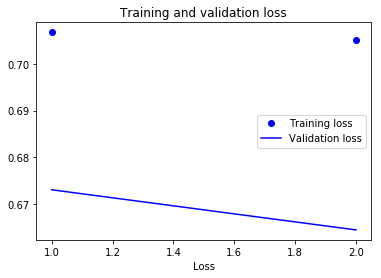

Using TensorFlow backend.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
2019-04-14 17:40:50.366176: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
merged AUC on testing data set: 0.8461285633441389
length of testing dataset:  1378120
merged AUC on training data set: 0.7590739291288362
length of training dataset:  4743090


In [26]:
import copy
import gc
import numpy as np
import pdb as check
import random
import modelfunctions
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
np.random.seed(42)


#set name of weights file and training/testing files
weightFile = '../Data/TheBestWeights.h5'
trainFile = '../Data/Training.h5' ##SWAPPED TRAIN AND TEST
testFile = '../Data/Testing.h5' ##SWAPPED TRAIN AND TEST
print ("training file:, ", trainFile)

#names of features
field_names_in = ['stresses_full_xx', 'stresses_full_yy', 'stresses_full_xy', 'stresses_full_xz','stresses_full_yz','stresses_full_zz']

#name of label
field_names_out = 'aftershocksyn'

#load training data set
IN_Train, OUT_Train = modelfunctions.LoadInputs(trainFile, field_names_in, field_names_out)

#pull out some validation data with positive grid cells upsampled so that validation data has equal numbers of positive and negative samples
posidx = np.where(OUT_Train==1)
numpos = np.size(posidx)
negidx = np.where(OUT_Train==0)
numneg = np.size(negidx)

#divide data into positive and negative samples
POSdata = np.column_stack((IN_Train[posidx,:][0], OUT_Train[posidx].T))
NEGdata = np.column_stack((IN_Train[negidx,:][0], OUT_Train[negidx].T))

np.random.seed(42) #shuffle order of samples (same way every time to ensure validation data does not change)
np.random.shuffle(POSdata)
np.random.shuffle(NEGdata)
np.random.seed() #reseed

cutoff = int(round(numpos/10)) #validation data consists of a random 10% of positive samples, and same number of randomly selected negative samples

#positive validation samples
val_in1 = copy.copy(POSdata[:cutoff,:len(field_names_in)*2])
val_out1 = copy.copy(POSdata[:cutoff,len(field_names_in)*2])

#negative validation samples
val_in2 = copy.copy(NEGdata[:cutoff,:len(field_names_in)*2])
val_out2 = copy.copy(NEGdata[:cutoff,len(field_names_in)*2])

#merge to obtain entire validation data set
val_in = np.row_stack((val_in1, val_in2))
val_out = np.append(val_out1, val_out2)

#the remaining data set is the training data set
POSdataFinal = copy.copy(POSdata[cutoff:,:])
NEGdataFinal = copy.copy(NEGdata[cutoff:,:])

shapepos = np.shape(POSdataFinal)

#set hyperparameters
batch_size = 300
#steps_per_epoch = int(round((shapepos[0])/batch_size)) #total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch, equal to the number of samples in dataset divided by the batch size
steps_per_epoch = 5
epoch_num = 2
posstart = 0
negstart = 0

#train
model = modelfunctions.create_model()
checkpointer = ModelCheckpoint(filepath=weightFile, monitor = 'val_loss', verbose=2, save_best_only = True)
history = model.fit_generator(modelfunctions.generate_data(POSdataFinal, NEGdataFinal, batch_size, posstart, negstart), steps_per_epoch, validation_data = (val_in, val_out),  callbacks = [checkpointer], verbose=2, epochs=epoch_num)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = list(range(1,len(loss)+1))
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.legend()
plt.show()

!python EvalModel2.py

***We get the same performance after passing 1500 rows of data in 2 epochs -- something is amiss.***

# 4. Leakage across similar aftershocks

In [35]:
import pandas as pd
df = pd.read_csv("names_train_ids.csv")

The name is the original filename and original is the authors placement of the data in either test or train.  As you can see, some aftershocks with the same name are split between test and train.  This could be a source of the potential leakage.  The easiest way is to use group partitioning, build the models, and compare the performance.  In this case, after using group partitioning my performance drops to an AUC of 0.77.  I am happy to share how I partitioned the dataset (I actually used 10 different randomly selected trials using group partitioning).  You can use the ID field for group partitioning.


In [36]:
df

,Name,Original,Change,ID
0,1968HYUGAx01YAGI_grid.csv,TRAIN,NaN,1
1,1968TOKACH01NAGA_grid.csv,TRAIN,NaN,2
2,1969GIFUxK01TAKE_grid.csv,TRAIN,NaN,3
3,1971SANFER01HEAT_grid.csv,TRAIN,NaN,4
4,1974IZUxHA01TAKE_grid.csv,TRAIN,NaN,5
5,1974PERUCE01HART_grid.csv,TRAIN,NaN,6
6,1978MIYAGI01YAMA_grid.csv,TEST,NaN,7
7,1978TABASI01HART_grid.csv,TEST,NaN,8
8,1979COYOTE01LIUx_grid.csv,TRAIN,NaN,9
9,1979IMPERI01ARCH_grid.csv,TEST,NaN,10
